In [1]:
%load_ext autoreload
%autoreload 2

In [16]:
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

import networkx as nx

from minimal.imaging import draw_plan, blit_rooms
from minimal.layout import NodeType, NODE_COLOR, NODE_NAME
from minimal import sample_graphs
from minimal.gen import _load_segmentation_dict
from minimal.lib import gen_segmentation_mask, assemble_plan
from minimal.doors import create_cut_wall_mask

%matplotlib inline

In [15]:
# layout, masks = _load_segmentation_dict(torch.load("data/sgm_01.pth"))

In [18]:
layout = sample_graphs.two()

In [20]:
%%time

masks = gen_segmentation_mask(layout)

CPU times: user 1min 24s, sys: 9.32 s, total: 1min 33s
Wall time: 26.7 s


In [21]:
scale = (3, 3)

In [22]:
%%time

rect_graphs, sep_mask, doors = assemble_plan(layout, masks, scale)

CPU times: user 1.31 s, sys: 3.73 ms, total: 1.31 s
Wall time: 1.21 s


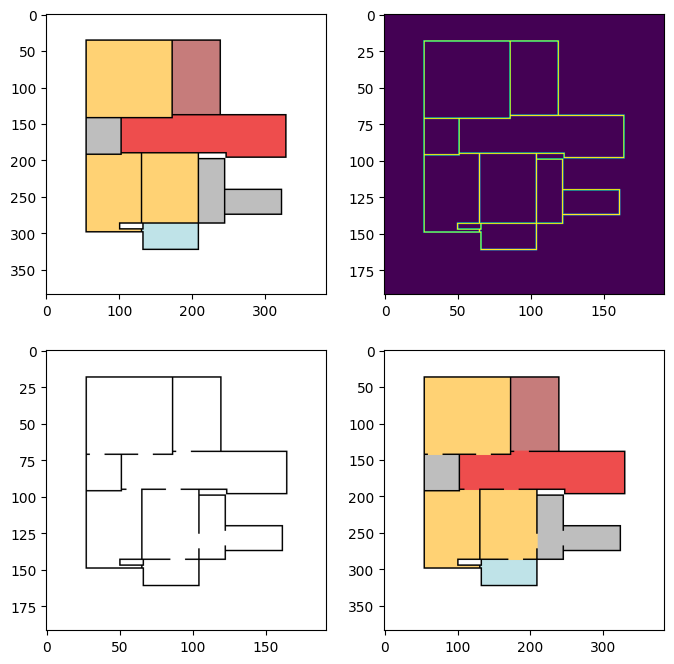

In [23]:
walls = create_cut_wall_mask(sep_mask, doors)

plt.figure(figsize=(8,8))

plt.subplot(221)
plt.imshow(blit_rooms(rect_graphs, sep_mask, out_size=384))

plt.subplot(222)
plt.imshow((sep_mask > 0).byte())

plt.subplot(223)
plt.imshow(1 - walls, cmap="gray")

plt.subplot(224)
plt.imshow(blit_rooms(rect_graphs, walls, out_size=384))